<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Experiments/axis_aligned_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax
from jax import random, grad, jit, vmap, lax
from jax.config import config
import jax.numpy as np
from jax.experimental import optimizers, stax
from jax.ops import index, index_update

import matplotlib.pyplot as plt
import os

import string

from tqdm.notebook import tqdm as tqdm

import numpy as onp

import scipy as sp

## Random seed
rand_key = random.PRNGKey(10)

In [ ]:
RES = 512
num_thetas = 17
num_rads = 4

thetas = np.linspace(0.0, np.pi, num_thetas)
rads = np.linspace(5.0, 20.0, num_rads)

def make_sinusoid_dataset(thetas, rads, RES):

  window = sp.signal.windows.hamming(RES)
  window_2d = np.outer(window, window)

  dataset = []
  for theta in thetas:
    rad_list = []
    for rad in rads:
      a = np.round(np.sin(theta)*rad)
      b = np.round(np.cos(theta)*rad)
      # y, x = np.meshgrid((np.arange(RES)-(RES//2))/RES, (np.arange(RES)-(RES//2))/RES, indexing='ij')
      y, x = np.meshgrid(np.linspace(0.0, 1.0, RES, endpoint=False), np.linspace(0.0, 1.0, RES, endpoint=False))
      tmp = np.cos(2.0*np.pi*a*x + 2.0*np.pi*b*y)[:,:,None]
      # rand_weight = onp.random.random()
      rad_list.append(tmp)
      # rad_list.append(sp.misc.face()[:RES,:RES,1:2]/255.0)
    dataset.append(rad_list)
    # dataset.append([np.mean(np.stack(rad_list, axis=0), axis=0)])
  return dataset

dataset = make_sinusoid_dataset(thetas, rads, RES)

x1 = np.linspace(0, 1, RES//2+1)[:-1]
x_train = np.stack(np.meshgrid(x1,x1), axis=-1)

x1_t = np.linspace(0, 1, RES+1)[:-1]
x_test = np.stack(np.meshgrid(x1_t,x1_t), axis=-1)

In [ ]:
def make_network(num_layers, num_channels):
  layers = []
  for i in range(num_layers-1):
      layers.append(stax.Dense(num_channels))
      layers.append(stax.Relu)
  layers.append(stax.Dense(1))
  layers.append(stax.Tanh)
  return stax.serial(*layers)

model_loss = jit(lambda params, x, y: .5 * np.mean((apply_fn(params, x) - y) ** 2))
model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
model_grad_loss = jit(lambda params, x, y: jax.grad(model_loss)(params, x, y))

def train_model(key, lr, iters, train_data, test_data):
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_update = jit(opt_update)

    _, params = init_fn(key, (-1, train_data[0].shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    xs = []
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)
        if i % 25 == 0:
            train_psnr = model_psnr(get_params(opt_state), *train_data)
            test_psnr = model_psnr(get_params(opt_state), *test_data)
            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            xs.append(i)
    results = {
        # 'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred' : apply_fn(get_params(opt_state), train_data[0])
    }
    return results['test_psnrs'][-1]

In [ ]:
input_encoder = lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x) @ b.T), 
                                                a * np.cos((2.*np.pi*x) @ b.T)], axis=-1)

def compute_new_posenc(mres):
  bvals = 2.**np.linspace(0,mres,embedding_size//2) - 1.
  bvals = np.stack([bvals, np.zeros_like(bvals)], -1)
  bvals = np.concatenate([bvals, np.roll(bvals, 1, axis=-1)], 0) + 0
  avals = np.ones((bvals.shape[0])) 
  return avals, bvals

def compute_gaussian(scale):
  bvals = random.normal(rand_key, (embedding_size, 2))*scale
  avals = np.ones((bvals.shape[0])) 
  return avals, bvals

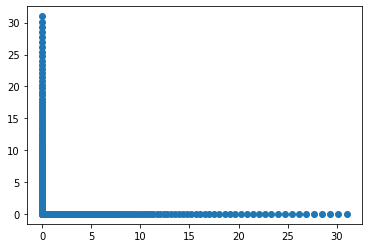

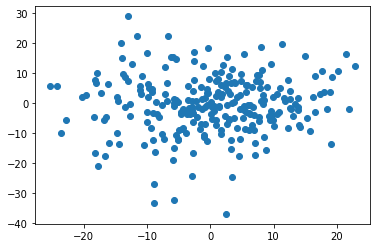

In [ ]:
network_depth =  2#@param
network_width = 256 #@param
lr =  1e-3#@param
training_steps =  500#@param

embedding_size = 256 #@param

posenc_mres = 5
gaussian_scale = 10

init_fn, apply_fn = make_network(network_depth, network_width)

avals, bvals = compute_new_posenc(posenc_mres)
plt.figure()
plt.scatter(bvals[:,0], bvals[:,1])

avals, bvals = compute_gaussian(gaussian_scale)
plt.figure()
plt.scatter(bvals[:,0], bvals[:,1])

In [ ]:
avals, bvals = compute_new_posenc(posenc_mres)
posenc_results = []
for t in tqdm(range(len(dataset)), desc=f'Angle', leave=False):
    theta = thetas[t]
    theta_results = []
    for r in tqdm(range(len(dataset[0])), desc=f'Radius', leave=False):
        rad = rads[r]
        y_train = dataset[t][r]
        train_data = (input_encoder(x_train, avals, bvals), y_train[::2,::2,:])
        test_data = (input_encoder(x_test, avals, bvals), y_train)
        theta_results.append(train_model(lr, training_steps, train_data, test_data))
    posenc_results.append(theta_results)

avals, bvals = compute_gaussian(gaussian_scale)
gaussian_results = []
for t in tqdm(range(len(dataset)), desc=f'Angle', leave=False):
    theta = thetas[t]
    theta_results = []
    for r in tqdm(range(len(dataset[0])), desc=f'Radius', leave=False):
        rad = rads[r]
        y_train = dataset[t][r]
        train_data = (input_encoder(x_train, avals, bvals), y_train[::2,::2,:])
        test_data = (input_encoder(x_test, avals, bvals), y_train)
        theta_results.append(train_model(lr, training_steps, train_data, test_data))
    gaussian_results.append(theta_results)

In [ ]:
posenc_psnrs = []
gaussian_psnrs = []
for i in range(len(posenc_results)):
  posenc_psnr_ang = []
  gaussian_psnr_ang = []
  for j in range(len(posenc_results[0])):
    posenc_psnr_ang.append(posenc_results[i][j]['test_psnrs'][-1])
    gaussian_psnr_ang.append(gaussian_results[i][j]['test_psnrs'][-1])
  posenc_psnrs.append(onp.mean(posenc_psnr_ang))
  gaussian_psnrs.append(onp.mean(gaussian_psnr_ang))

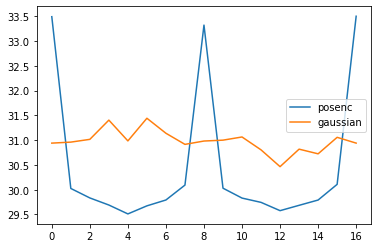

In [ ]:
plt.figure()
plt.plot(posenc_psnrs, label='posenc') 
plt.plot(gaussian_psnrs, label='gaussian')
plt.legend()

In [ ]:
def compute_gaussian(key, scale):
  bvals = random.normal(key, (embedding_size, 2))*scale
  avals = np.ones((bvals.shape[0])) 
  return avals, bvals

numruns = 4

train_fn = lambda ensemble_key, train_data, test_data: train_model(ensemble_key, lr, training_steps, train_data, test_data)

def train_fn_p(ensemble_key, x_train, x_test, y_train):
  avals, bvals = compute_new_posenc(posenc_mres)
  train_data = (input_encoder(x_train, avals, bvals), y_train[::2,::2,:])
  test_data = (input_encoder(x_test, avals, bvals), y_train)
  return train_fn(ensemble_key, train_data, test_data)

def train_fn_g(ensemble_key, x_train, x_test, y_train):
  avals, bvals = compute_gaussian(ensemble_key, gaussian_scale)
  train_data = (input_encoder(x_train, avals, bvals), y_train[::2,::2,:])
  test_data = (input_encoder(x_test, avals, bvals), y_train)
  return train_fn(ensemble_key, train_data, test_data)

train_fn_p = vmap(train_fn_p, in_axes=(0, None, None, None))
train_fn_g = vmap(train_fn_g, in_axes=(0, None, None, None))

rand_key, *ensemble_key = random.split(rand_key, 1+numruns)
ensemble_key = np.array(ensemble_key)

posenc_mres = 5
gaussian_scale = 10

# avals, bvals = compute_new_posenc(posenc_mres)
posenc_results = []
for t in tqdm(range(len(dataset)), desc='Angle', leave=False):
    theta = thetas[t]
    theta_results = []
    for r in tqdm(range(len(dataset[0])), desc='Radius', leave=False):
        rad = rads[r]
        y_train = dataset[t][r]
        # train_data = (input_encoder(x_train, avals, bvals), y_train[::2,::2,:])
        # test_data = (input_encoder(x_test, avals, bvals), y_train)
        # theta_results.append(train_fn_p(ensemble_key, train_data, test_data))
        theta_results.append(train_fn_p(ensemble_key, x_train, x_test, y_train))
    posenc_results.append(theta_results)

# avals, bvals = compute_gaussian(gaussian_scale)
gaussian_results = []
for t in tqdm(range(len(dataset)), desc='Angle', leave=False):
    theta = thetas[t]
    theta_results = []
    for r in tqdm(range(len(dataset[0])), desc='Radius', leave=False):
        rad = rads[r]
        y_train = dataset[t][r]
        # train_data = (input_encoder(x_train, avals, bvals), y_train[::2,::2,:])
        # test_data = (input_encoder(x_test, avals, bvals), y_train)
        # theta_results.append(train_fn(ensemble_key, train_data, test_data))
        theta_results.append(train_fn_g(ensemble_key, x_train, x_test, y_train))
    gaussian_results.append(theta_results)

In [ ]:
posenc_array = onp.array(posenc_results)
gaussian_array = onp.array(gaussian_results)

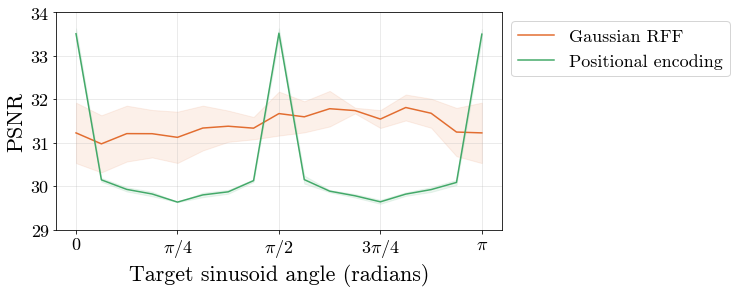

In [ ]:
import matplotlib
import matplotlib.pylab as pylab
params = {'legend.fontsize': 18,
         'axes.labelsize': 22,
         'axes.titlesize': 22,
         'xtick.labelsize': 18,
         'ytick.labelsize':18}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"

colors_k = np.array([[0.8872, 0.4281, 0.1875],
    # [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    # [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 2

fig = plt.figure(figsize=(8,4))
ax = plt.gca()

meanvals_p = np.mean(posenc_array, axis=(1,2))
stdvals_p = np.std(np.mean(posenc_array, axis=1), axis=1)

meanvals_g = np.mean(gaussian_array, axis=(1,2))
stdvals_g = np.std(np.mean(gaussian_array, axis=1), axis=1)

plt.plot(thetas, meanvals_g, color=colors_k[0], label='Gaussian RFF')
plt.fill_between(thetas, meanvals_g-stdvals_g, meanvals_g+stdvals_g, color=colors_k[0], alpha=.1)

plt.plot(thetas, meanvals_p, color=colors_k[1], label='Positional encoding')
plt.fill_between(thetas, meanvals_p-stdvals_p, meanvals_p+stdvals_p, color=colors_k[1], alpha=.1)

plt.autoscale(enable=True, axis='y', tight=True)
plt.xticks([0.0, np.pi/4., np.pi/2., 3.*np.pi/4., np.pi], 
           ['0','$\pi/4$','$\pi/2$', '$3\pi/4$', '$\pi$'])
# ax.set_yticklabels([fr'${t:g}$' for t in ytick])
ax.set_ylim([29,34])
plt.xlabel('Target sinusoid angle (radians)')
plt.ylabel('PSNR')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(True, which="both", ls='-', alpha=.3)

plt.savefig('axis-aligned.pdf', bbox_inches='tight', pad_inches=0)

plt.show()